<a href="https://www.kaggle.com/code/lakshmipriya190803/reddit-comments-analysis-using-nlp-and-dl?scriptVersionId=159604343" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Welcome :)

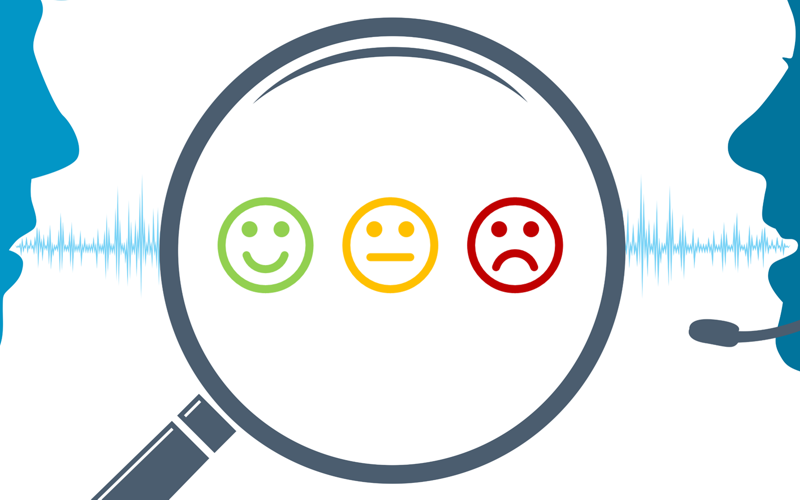

Let's explore Reddit Comments Sentiment Analysis using Machine Learning and Deep Learning. 

# Exploratory Data Analysis

Exploratory Data Analysis (EDA) is essential for effective sentiment analysis. It helps understand sentiment label distribution, identify text preprocessing needs, and select relevant features. EDA also addresses imbalanced classes, detects outliers, and visualizes data trends. This process enhances model interpretability and ensures robust sentiment analysis by informing decisions on preprocessing steps, feature selection, and model design.

In [1]:
import pandas as pd 
import numpy as np
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 

from nltk.tokenize import RegexpTokenizer
import re
import string

In [2]:
df_1 = pd.read_csv("/kaggle/input/chatgpt-reddit/chatgpt-reddit-comments.csv")
df_1.head(5)

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit
0,0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT
1,1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT
2,2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT
3,3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT
4,4,izu2as9,t3_zj2aeu,"Certified 10/10, must-see moment. It really di...",r/ChatGPT


In [3]:
df_1.describe()

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit
count,52413,52415,52415,52415,52415
unique,29712,52413,22596,51042,5
top,0,comment_id,t3_107vs7i,[deleted],r/ChatGPT
freq,4,3,239,661,29711


In [4]:
print(f"Null values ? \n{df_1.isnull().sum()}")

Null values ? 
Unnamed: 0           3
comment_id           1
comment_parent_id    1
comment_body         1
subreddit            1
dtype: int64


In [5]:
print("since we've got some null values, let's remove that first")
df_1.dropna(inplace = True)
df_1.isna().sum()
print(f"Null values ? \n{df_1.isnull().sum()}")

since we've got some null values, let's remove that first
Null values ? 
Unnamed: 0           0
comment_id           0
comment_parent_id    0
comment_body         0
subreddit            0
dtype: int64


so far we can see the first column just contains the index, we've got id of the person commenting, what they've commented and the subreddit, NO *labels*

there are so many patterns we could look for
is there any relation between the average sentiment of comments and subreddits?
how is the overall sentiment of comments

My overall focus is going to be on comments themselves so commenter's id will be irrelevant
Although one thing I might go on look further a person would be whether they were siding with the group and how many were like them or whether their opinions stayed constant throughout subreddits 
this will be something i would look at, at the very last obviously!


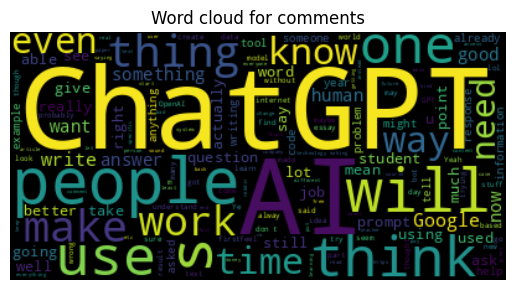

In [6]:
comments = df_1['comment_body']
text = ' '.join(comments.astype(str).tolist())

wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word cloud for comments")
plt.show()

## Data Prep using Stemming and lemmatizing 

Okay from now on I will be focusing entirely on the 'Comment body' 
We do not have labels so there's two things we could do:

1. Go unsupervised
2. Use sentiment analysers to give a rating to each comment based on lexicon

Let's try both and see where we go
Either way the data needs to be cleaned before we proceed further

In [7]:
df = df_1['comment_body']
df.head(5)

0    I've been shocked for days now, I don't need c...
1     \n\nI am so angry right now. I just wasted my...
2    chatgpt karma whoring is here folks! just when...
3                                   Worked on me, ngl.
4    Certified 10/10, must-see moment. It really di...
Name: comment_body, dtype: object

In [8]:
#converting all text to lowercase
df = df.str.lower()
df.head(5)

0    i've been shocked for days now, i don't need c...
1     \n\ni am so angry right now. i just wasted my...
2    chatgpt karma whoring is here folks! just when...
3                                   worked on me, ngl.
4    certified 10/10, must-see moment. it really di...
Name: comment_body, dtype: object

In [9]:
#cleaning and removing stopwords
stopwords_list = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopwords_list])

df = df.apply(lambda text : cleaning_stopwords(text))
df.head()

0               i've shocked days now, need clickbait.
1    angry right now. wasted time reading post sub ...
2    chatgpt karma whoring folks! think stream thou...
3                                      worked me, ngl.
4    certified 10/10, must-see moment. really shock...
Name: comment_body, dtype: object

In [10]:
#cleaning and removing punctuations 
english_punctuations = string.punctuation

def cleaning_punctuations(text):
    translator = str.maketrans('','', english_punctuations)
    return text.translate(translator)

df = df.apply(lambda x: cleaning_punctuations(x))
df.head(5)

0                  ive shocked days now need clickbait
1    angry right now wasted time reading post sub c...
2    chatgpt karma whoring folks think stream thoug...
3                                        worked me ngl
4      certified 1010 mustsee moment really shock core
Name: comment_body, dtype: object